In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["erddapy", "ipyleaflet", "seawater"]
_colab_install_missing_deps(deps)

# Searching multiple ERDDAP servers

Created: 2021-10-19

The latest erddapy module release (v1.2.0) added a multiple servers search similar to the web one implemented in
[https://mathewbiddle.github.io/search-erddaps](https://mathewbiddle.github.io/search-erddaps).
The Python interface allow the user to mix powerful variable handling and visualization with the query results.

Let us explore an example
[based on this](https://nbviewer.org/gist/rsignell-usgs/f2be18f9db07a3c2970d88576cd62b57)
Rich Signell's gist where we search for salinity time-series data in a specific region and time span.

In [2]:
min_time = "2017-07-01T00:00:00Z"
max_time = "2017-09-01T00:00:00Z"
min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48
standard_name = "sea_water_practical_salinity"


kw = {
    "standard_name": standard_name,
    "min_lon": min_lon,
    "max_lon": max_lon,
    "min_lat": min_lat,
    "max_lat": max_lat,
    "min_time": min_time,
    "max_time": max_time,
    "cdm_data_type": "timeseries",
}


servers = {
    "ooi": "https://erddap.dataexplorer.oceanobservatories.org/erddap/",
    "ioos": "https://erddap.sensors.ioos.us/erddap/",
}

We will restrict the search to two servers, IOOS sensors and OOI Data Explorer. If one leaves the `server_list` empty the search will iterate all servers listed in the
[Awesome ERDDAP list](https://github.com/IrishMarineInstitute/awesome-erddap).

In [3]:
from erddapy.multiple_server_search import advanced_search_servers

df = advanced_search_servers(servers_list=servers.values(), **kw)

df.head()

Title  \
0  Coastal Endurance: Oregon Inshore Surface Moor...   
1  Coastal Endurance: Oregon Inshore Surface Moor...   
2  Coastal Endurance: Oregon Inshore Surface Moor...   
3  Coastal Endurance: Oregon Inshore Surface Moor...   
4  Coastal Endurance: Oregon Inshore Surface Moor...   

                            Institution                       Dataset ID  \
0  Ocean Observatories Initiative (OOI)  ooi-ce01issm-rid16-02-flortd000   
1  Ocean Observatories Initiative (OOI)  ooi-ce01issm-rid16-03-ctdbpc000   
2  Ocean Observatories Initiative (OOI)  ooi-ce01issm-rid16-03-dostad000   
3  Ocean Observatories Initiative (OOI)  ooi-ce01issm-rid16-07-nutnrb000   
4  Ocean Observatories Initiative (OOI)  ooi-ce01issm-rid16-06-phsend000   

                                          Server url  
0  https://erddap.dataexplorer.oceanobservatories...  
1  https://erddap.dataexplorer.oceanobservatories...  
2  https://erddap.dataexplorer.oceanobservatories...  
3  https://erddap.dataexplorer.oceanobservatories...  
4  https://erddap.dataexplorer.oceanobservatories...

Now that we have a list of dataset_ids we can iterate and get their positions to create a map.
The functions below will create a download URL for the longitude and latitude and request the data as a pandas dataframe.

In [4]:
import pandas as pd
from erddapy import ERDDAP

kw = {
    "longitude>=": min_lon,
    "longitude<=": max_lon,
    "latitude>=": min_lat,
    "latitude<=": max_lat,
    "time>=": min_time,
    "time<=": max_time,
}


def download_url(server, dataset_id):
    e = ERDDAP(server, protocol="tabledap")
    url = e.get_download_url(
        dataset_id=dataset_id,
        response="csvp",
        variables=["longitude", "latitude"],
        constraints=kw,
        distinct=True,
    )
    return url


def request_positions(download_url):
    df = pd.read_csv(download_url)
    return df.values.squeeze().tolist()

Now we can iterate all the dataset ids we found. That is a slow operation depending on the number of datasets and it is good practice to save/cache the results to re-use them later. That will not only save us some time but it is also appreciated by the data providers maintaining the servers.

In [5]:
import pickle
from pathlib import Path
from urllib.error import HTTPError

import numpy as np
from tqdm.notebook import tqdm

path = Path("positions.p")

if not path.exists():
    positions = []
    for idx, row in tqdm(df.iterrows()):
        try:
            url = download_url(row["Server url"], row["Dataset ID"])
            pos = request_positions(url)
        except HTTPError:
            pos = [np.nan, np.nan]
        positions.append(pos)
    with open(path, "wb") as f:
        pickle.dump(positions, f)
else:
    with open(path, "rb") as f:
        positions = pickle.load(f)

0it [00:00, ?it/s]

In [6]:
df.loc[:, "lon"] = np.array(positions)[:, 0]
df.loc[:, "lat"] = np.array(positions)[:, 1]

df.dropna(inplace=True)

df_ioos = df.loc[df["Server url"] == servers["ioos"]]
df_ooi = df.loc[df["Server url"] == servers["ooi"]]

In [7]:
from ipyleaflet import (
    AwesomeIcon,
    FullScreenControl,
    LegendControl,
    Map,
    Marker,
    Rectangle,
)
from ipywidgets import HTML

colors = {
    "IOOS": "blue",
    "OOI": "orange",
}


legend = LegendControl(
    colors,
    name="Dataset locations",
    position="bottomright",
)


def make_popup(row):
    classes = "table table-striped table-hover table-condensed table-responsive"
    return pd.DataFrame(row[["Institution", "Dataset ID"]]).to_html(classes=classes)

In [8]:
m = Map(center=((min_lat + max_lat) / 2, (min_lon + max_lon) / 2), zoom=6)
m.add_control(FullScreenControl())
m.add_control(legend)

rectangle = Rectangle(
    bounds=((min_lat, min_lon), (max_lat, max_lon)),
    color="red",
    fill=False,
)
m.add_layer(rectangle)

In [9]:
# IOOS
for k, row in df_ioos.iterrows():
    marker = Marker(
        icon=AwesomeIcon(name="life-ring", marker_color=colors["IOOS"]),
        location=(row["lat"], row["lon"]),
    )
    msg = HTML()
    msg.value = make_popup(row)
    marker.popup = msg
    m.add_layer(marker)

In [10]:
# OOI
for k, row in df_ooi.iterrows():
    marker = Marker(
        icon=AwesomeIcon(name="life-ring", marker_color=colors["OOI"]),
        location=(row["lat"], row["lon"]),
    )
    msg = HTML()
    msg.value = make_popup(row)
    marker.popup = msg
    m.add_layer(marker)

In [11]:
m

Map(center=[45.5, -125.375], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

User may also look for data that are located near to each other for sensor comparison or calibration.
The nested loop below is a simple way to find the stations that are nearest to each other starting from a 1 km distance.

In [12]:
import seawater as sw

dist = 1e3
for k_i, (lon_i, lat_i) in df_ioos[["lon", "lat"]].iterrows():
    for k_o, (lon_o, lat_o) in df_ooi[["lon", "lat"]].iterrows():
        lats = lat_i, lat_o
        lons = lon_i, lon_o
        new_dist, angle = sw.dist(lats, lons)
        if new_dist < dist:
            dist = new_dist
            ki, ko = k_i, k_o

/tmp/ipykernel_97295/2922289694.py:1: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [13]:
print(f"The stations closest ({dist.squeeze():.2f} km) to each other are:")

The stations closest (42.05 km) to each other are:


In [14]:
df.loc[ki]

Title                   Cape Elizabeth, WA, Historic MAPCO2
Institution    NOAA Pacific Marine Environmental Lab (PMEL)
Dataset ID                       gov_ornl_cdiac_wa_125w_47n
Server url           https://erddap.sensors.ioos.us/erddap/
lon                                                 -124.73
lat                                                   47.35
Name: 70, dtype: object

In [15]:
df.loc[ko]

Title          Coastal Endurance: Washington Shelf Surface Mo...
Institution                 Ocean Observatories Initiative (OOI)
Dataset ID                       ooi-ce07shsm-rid27-02-flortd000
Server url     https://erddap.dataexplorer.oceanobservatories...
lon                                                   -124.56771
lat                                                     46.98805
Name: 53, dtype: object

In [16]:
def download_salinity(server, dataset_id):
    print(f"Downloading {dataset_id=}.")
    e = ERDDAP(server, protocol="tabledap")
    e.dataset_id = dataset_id
    e.constraints = {"time>=": min_time, "time<=": max_time}
    e.response = "csv"
    e.variables = [
        "time",
        e.get_var_by_attr(dataset_id=dataset_id, standard_name=standard_name)[0],
    ]

    col = "time (UTC)"
    return e.to_pandas(parse_dates=[col], index_col=col)

In [17]:
dataset_id = df.loc[ki]["Dataset ID"]

sal_ioos = download_salinity(servers["ioos"], dataset_id)

In [18]:
dataset_id = df.loc[ko]["Dataset ID"]

sal_ooi = download_salinity(servers["ooi"], dataset_id)

<IPython.core.display.Javascript object>


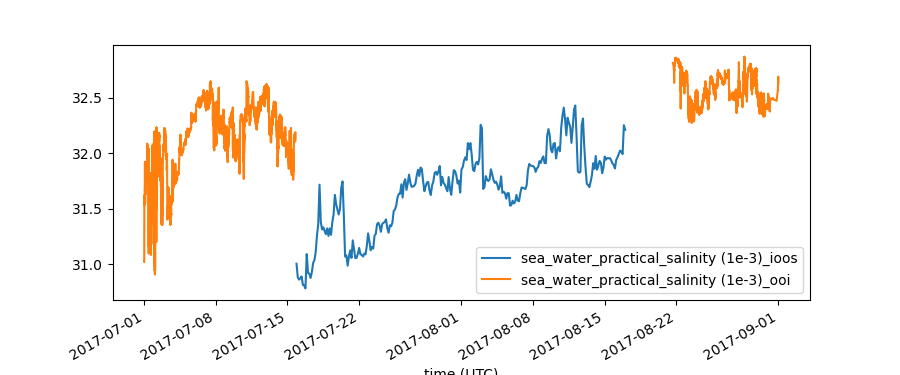

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


fig, ax = plt.subplots(figsize=(9, 3.75))
pd.merge(
    sal_ioos, sal_ooi, on="time (UTC)", suffixes=("_ioos", "_ooi"), how="outer"
).plot(ax=ax)
fig.autofmt_xdate();

Hopefully this new feature is useful and be sure to also check the simple search functionality (`search_servers`) in case one wants to browse data without extra constraints.